## Fruits and Vegetables Classification

Given dataset containing 101 different fruit and vegetable classes we are going to try to classify them.

In [1]:
import os
import matplotlib.pyplot as plt
import preparing_data

%matplotlib inline

ZIP_PATH = os.path.join(os.getcwd(), 'data/fruits_vegetables/archive.zip')
UNZIP_PATH = os.path.join(os.getcwd(), 'data/fruits_vegetables/')

In [2]:
preparing_data.unzip_data(ZIP_PATH, UNZIP_PATH, True)

In [2]:
TEST_PATH = os.path.join(UNZIP_PATH, 'fruits-360_dataset/fruits-360/Test/')
TRAINING_PATH = os.path.join(UNZIP_PATH, 'fruits-360_dataset/fruits-360/Training/')
VALIDATION_PATH = os.path.join(UNZIP_PATH, 'fruits-360_dataset/fruits-360/Validation/')

In [5]:
import random
from shutil import move


def split_test_val(test_path, validation_path, split_size):
    """
    Split test set to train/validation set with specified size

    Args:
      test_path (string): directory path containing test samples
      validation_path (string): path to be validation directory
      split_size (float): portion of the dataset to be used for validation

    Returns:
      None
    """
    test_dirs = os.listdir(test_path)
    
    for dir in test_dirs:
        path = os.path.join(test_path, dir)
        samples_test = os.listdir(path)
        num_samples = int(len(samples_test) * split_size)
        shuffled_dir = random.sample(samples_test, len(samples_test))

        validation_dir = os.path.join(validation_path, dir)
        os.makedirs(validation_dir)
        for img in shuffled_dir[:num_samples]:
            img_path = os.path.join(path, img)
            img_val_path = os.path.join(validation_dir, img)
            move(img_path, img_val_path)


split_test_val(TEST_PATH, VALIDATION_PATH, 0.7)

train = preparing_data.data_counter(TRAINING_PATH, 'Training')
test = preparing_data.data_counter(TEST_PATH, 'Test')
validation = preparing_data.data_counter(VALIDATION_PATH, 'Validation')


Number of files in Training is 67692
Number of files in Test is 6864
Number of files in Validation is 15824


In [6]:
assert train.keys() == test.keys() == validation.keys()

In [3]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.15,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   height_shift_range=0.15,
                                   rotation_range=45)
training_data = train_datagen.flow_from_directory(directory=TRAINING_PATH,
                                                  class_mode='categorical',
                                                  target_size=(100, 100),
                                                  batch_size=64)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

validation_data = validation_datagen.flow_from_directory(directory=VALIDATION_PATH,
                                                        class_mode='categorical',
                                                        target_size=(100, 100),
                                                        batch_size=128)

test_data = test_datagen.flow_from_directory(directory=TEST_PATH,
                                            class_mode='categorical',
                                            target_size=(100, 100),
                                            batch_size=1)

Found 67692 images belonging to 131 classes.
Found 15824 images belonging to 131 classes.
Found 6864 images belonging to 131 classes.


# Transfer Learning

### ResNet152 architecture trainable with imagenet weights initialized

In [4]:
from keras import Model
from keras.layers import Flatten, Dense, Dropout
from keras.applications.resnet import ResNet152

resnet = ResNet152(include_top=False,
                   weights='imagenet',
                   input_shape=(100, 100, 3))

x = Flatten()(resnet.get_layer('conv5_block3_out').output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(131, activation='softmax')(x)


model_v1 = Model(resnet.input, x)

model_v1.summary()
model_v1.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model_v1.fit(training_data,
            epochs=10,
            validation_data=validation_data)

2022-07-04 10:54:08.472416: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 10:54:08.522004: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 10:54:08.522139: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 10:54:08.522631: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']         

2022-07-04 10:54:24.331393: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-07-04 10:54:25.464574: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-04 10:54:25.465833: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-04 10:54:25.465856: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-07-04 10:54:25.467154: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-04 10:54:25.467214: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1058/1058 [==============================] - 318s 288ms/step - loss: 2.0278 - accuracy: 0.4706 - val_loss: 4.2666 - val_accuracy: 0.2780
Epoch 2/10
1058/1058 [==============================] - 293s 277ms/step - loss: 0.4707 - accuracy: 0.8521 - val_loss: 4.1990 - val_accuracy: 0.3986
Epoch 3/10
 212/1058 [=====>........................] - ETA: 3:45 - loss: 0.3527 - accuracy: 0.8903

We can see after 10 epochs we get validation accuracy 82%, but  training proces was unstable looking at validation accuracy over the epochs

### ResNet152 with imagenet weights

This model is trained on ResNet152 architecture with imagenet weights and non trainable layers except those added at the end by me.

In [13]:

resnet_nt = ResNet152(include_top=False,
                   weights='imagenet',
                   input_shape=(100, 100, 3))

for layer in resnet_nt.layers:
    layer.trainable = False

x = Flatten()(resnet_nt.get_layer('conv5_block3_out').output)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(131, activation='softmax')(x)


model_without_trainable = Model(resnet_nt.input, x)

model_without_trainable.summary()
model_without_trainable.compile(optimizer='adam',
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])
history_without_trainable = model_without_trainable.fit(training_data,
                                                        epochs=10,
                                                        validation_data=validation_data)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']       

### ResNet152 without included weights

This model is trained on ResNet152 architecture with all parameters trainable without initialized weights.

In [16]:
resnet_vanila = ResNet152(include_top=False,
                   weights=None,
                   input_shape=(100, 100, 3))

x = Flatten()(resnet_vanila.get_layer('conv5_block3_out').output)
x = Dense(2048, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(131, activation='softmax')(x)


model_resnet_vanila = Model(resnet_vanila.input, x)

model_resnet_vanila.summary()
model_resnet_vanila.compile(optimizer='adam',
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])
history_resnet_vanila = model_resnet_vanila.fit(training_data,
                                                        epochs=20,
                                                        validation_data=validation_data)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']       

2022-07-03 20:08:05.144076: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 737.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-07-03 20:08:05.212771: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-07-03 20:08:05.217909: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-07-03 20:08:05.226838: W tensorflow/core/common_runtime/bfc_alloca

1058/1058 [==============================] - 306s 279ms/step - loss: 4.2667 - accuracy: 0.0622 - val_loss: 2.6079 - val_accuracy: 0.2022
Epoch 2/20
1058/1058 [==============================] - 298s 282ms/step - loss: 1.9724 - accuracy: 0.3725 - val_loss: 1.7908 - val_accuracy: 0.4510
Epoch 3/20
1058/1058 [==============================] - 298s 281ms/step - loss: 1.0279 - accuracy: 0.6637 - val_loss: 0.5998 - val_accuracy: 0.8176
Epoch 4/20
1058/1058 [==============================] - 298s 282ms/step - loss: 0.7013 - accuracy: 0.7775 - val_loss: 0.5361 - val_accuracy: 0.8421
Epoch 5/20
1058/1058 [==============================] - 298s 281ms/step - loss: 0.7325 - accuracy: 0.7757 - val_loss: 2.8018 - val_accuracy: 0.3493
Epoch 6/20
1058/1058 [==============================] - 298s 281ms/step - loss: 0.8999 - accuracy: 0.7345 - val_loss: 2.2569 - val_accuracy: 0.4524
Epoch 7/20
1058/1058 [==============================] - 297s 281ms/step - loss: 0.7542 - accuracy: 0.7636 - val_loss: 0.456

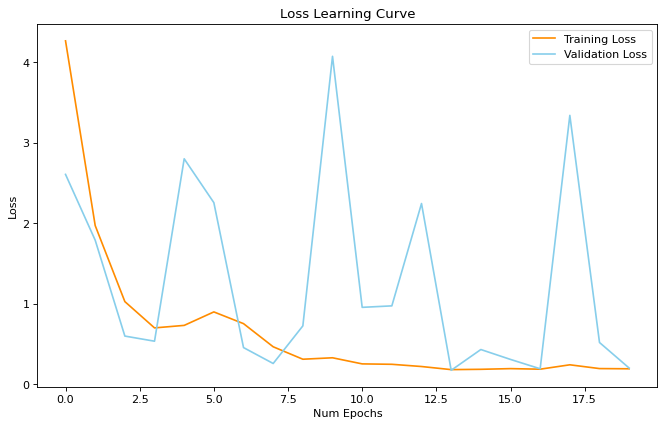

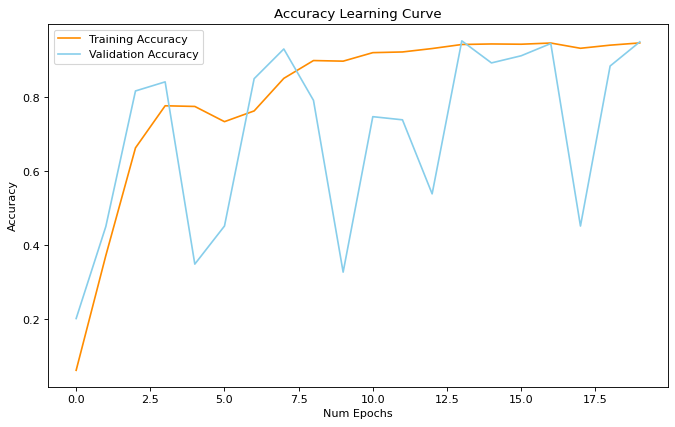

In [19]:
def plot_learning(model, train_param, val_param, xtitle, ytitle, plot_title, label_1, label_2):
    plt.figure(dpi=80, figsize=(10,6))
    plt.plot(model.history[train_param],
            label=label_1,
            color='darkorange')
    plt.plot(model.history[val_param],
            label=label_2,
            color='skyblue')
    plt.legend()
    plt.title(plot_title)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)

plot_learning(history_resnet_vanila, 'loss', 'val_loss', xtitle='Num Epochs', ytitle='Loss', plot_title='Loss Learning Curve', label_1='Training Loss', label_2='Validation Loss')
plot_learning(history_resnet_vanila, 'accuracy', 'val_accuracy', 'Num Epochs', 'Accuracy', plot_title='Accuracy Learning Curve', label_1='Training Accuracy', label_2='Validation Accuracy')

Our model achieve 95% accuracy on validation set after 20 epochs. It is our best of so far seen 3 models so we are going to test this model on our test set and evaluate it's final performance

In [22]:
model_resnet_vanila.evaluate(test_data)

54/54 [==============================] - 7s 136ms/step - loss: 0.1983 - accuracy: 0.9510


[0.1983119249343872, 0.9510489702224731]

As we can see ResNet152 trained from scratch on our fruits and vegetables dataset performed pretty well scoring 95% on test set.

## GooLeNet architecture 

We are going to train another model from scratch on our dataset since we saw that it reaches better accuracy when trained from scratch than with initialized weights from for example imagenet

### Inception without weights

In [26]:
from keras.applications.inception_v3 import InceptionV3

inception_model = InceptionV3(include_top=False,
                              weights=None,
                              input_shape=(100, 100, 3))

z = Flatten()(inception_model.get_layer('mixed10').output)
z = Dense(1024, activation='relu')(z)
z = Dropout(0.5)(z)
z = Dense(131, activation='softmax')(z)

inception_vanila = Model(inception_model.input, z)
inception_vanila.summary()

inception_vanila.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

history_inception_vanila = inception_vanila.fit(training_data,
                                                epochs=20,
                                                validation_data=validation_data)


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_282 (Conv2D)            (None, 49, 49, 32)   864         ['input_8[0][0]']                
                                                                                                  
 batch_normalization_282 (Batch  (None, 49, 49, 32)  96          ['conv2d_282[0][0]']             
 Normalization)                                                                                   
                                                                                            

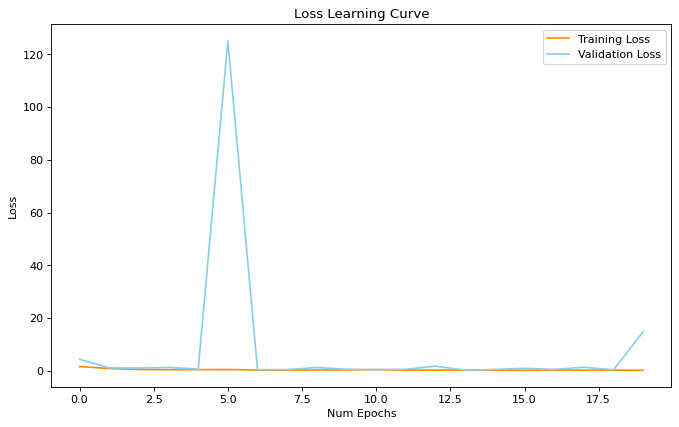

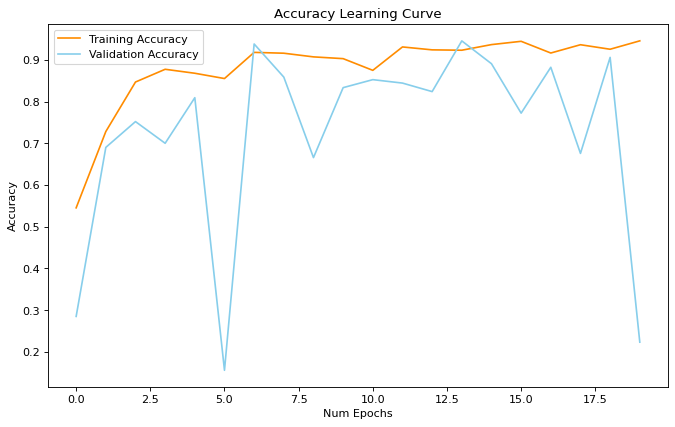

In [27]:
plot_learning(history_inception_vanila, 'loss', 'val_loss', xtitle='Num Epochs', ytitle='Loss', plot_title='Loss Learning Curve', label_1='Training Loss', label_2='Validation Loss')
plot_learning(history_inception_vanila, 'accuracy', 'val_accuracy', 'Num Epochs', 'Accuracy', plot_title='Accuracy Learning Curve', label_1='Training Accuracy', label_2='Validation Accuracy')

Training with inception model was pretty "shakey", to get best performance we could stop at epoch 12.

In [30]:
#Confusing name, my mistake, it is still vanila model trained further.
history_inception_imagenet = inception_vanila.fit(training_data,
                                                epochs=20,
                                                validation_data=validation_data)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_470 (Conv2D)            (None, 49, 49, 32)   864         ['input_10[0][0]']               
                                                                                                  
 batch_normalization_470 (Batch  (None, 49, 49, 32)  96          ['conv2d_470[0][0]']             
 Normalization)                                                                                   
                                                                                            

In [35]:
inception_vanila.evaluate(test_data)

54/54 [==============================] - 2s 32ms/step - loss: 0.1470 - accuracy: 0.9735


[0.14703655242919922, 0.9734848737716675]

Text(0.5, 1.0, 'InceptionV3 40 Epochs no weights initialization')

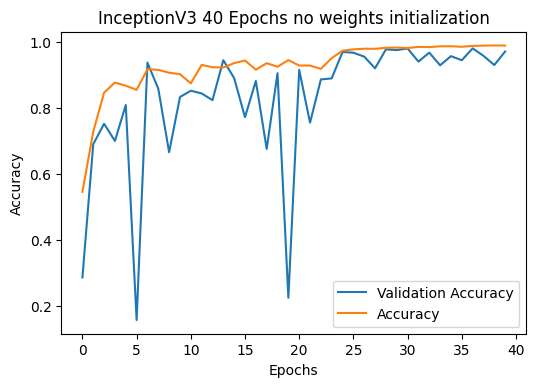

In [46]:
val_his_inception_vanila = history_inception_vanila.history['val_accuracy'] + history_inception_imagenet.history['val_accuracy'] 
acc_his_inception_vanila = history_inception_vanila.history['accuracy'] + history_inception_imagenet.history['accuracy'] 

plt.figure(dpi=100)
plt.plot(val_his_inception_vanila, label='Validation Accuracy')
plt.plot(acc_his_inception_vanila, label='Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('InceptionV3 40 Epochs no weights initialization')

### Inception imagenet weights

In [47]:
imagenet_inception = InceptionV3(include_top=False,
                                weights='imagenet',
                                input_shape=(100, 100, 3))

f = Flatten()(imagenet_inception.get_layer('mixed10').output)
f = Dense(1024, activation='relu')(f)
f = Dropout(0.5)(f)
f = Dense(131, activation='softmax')(f)

inceptionv3_imagenet = Model(imagenet_inception.input, f)

inceptionv3_imagenet.compile(optimizer='adam',
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])
inceptionv3_imagenet_history = inceptionv3_imagenet.fit(training_data,
                                                        epochs=20,
                                                        validation_data=validation_data)

Epoch 1/20
1058/1058 [==============================] - 113s 103ms/step - loss: 1.3925 - accuracy: 0.6327 - val_loss: 2.0837 - val_accuracy: 0.7128
Epoch 2/20
1058/1058 [==============================] - 107s 101ms/step - loss: 0.3768 - accuracy: 0.8923 - val_loss: 3.4451 - val_accuracy: 0.4659
Epoch 3/20
1058/1058 [==============================] - 108s 102ms/step - loss: 0.3346 - accuracy: 0.9055 - val_loss: 1.3878 - val_accuracy: 0.7252
Epoch 4/20
1058/1058 [==============================] - 108s 102ms/step - loss: 0.1460 - accuracy: 0.9586 - val_loss: 0.1811 - val_accuracy: 0.9519
Epoch 5/20
1058/1058 [==============================] - 109s 102ms/step - loss: 0.1130 - accuracy: 0.9665 - val_loss: 0.2971 - val_accuracy: 0.9189
Epoch 6/20
1058/1058 [==============================] - 111s 105ms/step - loss: 0.1079 - accuracy: 0.9694 - val_loss: 0.5534 - val_accuracy: 0.8916
Epoch 7/20
1058/1058 [==============================] - 108s 102ms/step - loss: 0.0972 - accuracy: 0.9723 - val_

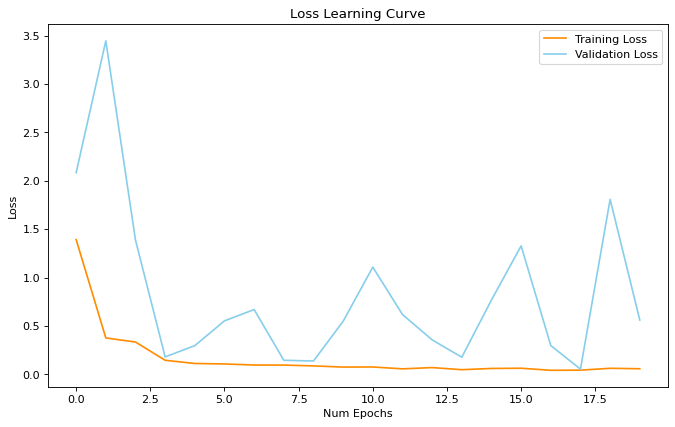

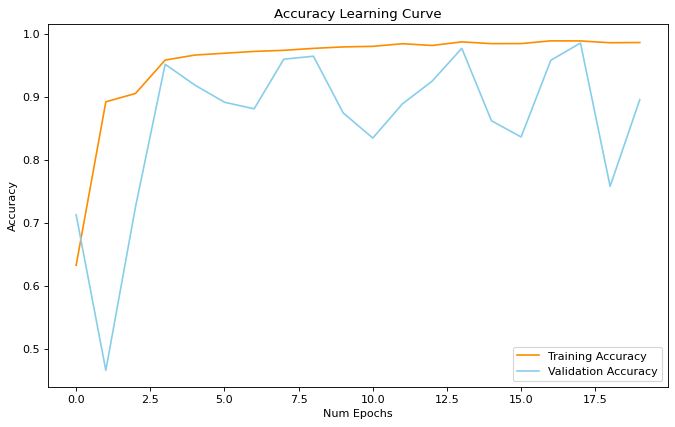

In [55]:
plot_learning(inceptionv3_imagenet_history, 'loss', 'val_loss', xtitle='Num Epochs', ytitle='Loss', plot_title='Loss Learning Curve', label_1='Training Loss', label_2='Validation Loss')
plot_learning(inceptionv3_imagenet_history, 'accuracy', 'val_accuracy', 'Num Epochs', 'Accuracy', plot_title='Accuracy Learning Curve', label_1='Training Accuracy', label_2='Validation Accuracy')